Przed oddaniem zadania upewnij się, że wszystko działa poprawnie.
**Uruchom ponownie kernel** (z paska menu: Kernel$\rightarrow$Restart) a następnie
**wykonaj wszystkie komórki** (z paska menu: Cell$\rightarrow$Run All).

Upewnij się, że wypełniłeś wszystkie pola `TU WPISZ KOD` lub `TU WPISZ ODPOWIEDŹ`, oraz
że podałeś swoje imię i nazwisko poniżej:

In [ ]:
NAME = "Maciej Wilhelmi"

---

# 2. Model TNC

Przedstawimy teraz zasadę działania modelu TNC, zaimplementujemy jego  najistotniejsze elementy oraz dokonamy ewaluacji modelu.

## 2.1. Idea modelu TNC
Dla ciągu czasowego $X \in \mathbb{R}^{D \times T}$ możemy określić okno przesuwne $X_{[t - \frac{\delta}{2}, t + \frac{\delta}{2}]}$ o długości $\delta$ wycentrowane wokół chwili $t$, które zawiera pomiary wszystkich cech w przedziale czasu $[t - \frac{\delta}{2}, t + \frac{\delta}{2}]$. Dla ułatwienia zapisu okno to będzie oznaczane jako $W_t$.

Celem metody uczenia reprezentacji będzie uzyskanie wektorowej reprezentacji dowolnego okna $W_t$.

### Temporalne sąsiedztwo
Dla okna $W_t$ zdefiniujmy jego temporalne sąsiedztwo $N_t$ jako zbiór wszystkich okien wycentrowanych w $t^*$, gdzie wartość ta jest próbkowana z rozkładu normalnego $t^* \sim \mathcal{N}(t, \eta \cdot \delta)$. Parametr $\eta$ definiuje szerokość / zakres sąsiedztwa temporalnego.

Wybór parametru $\eta$ może być oparty o wiedzę ekspercką, jednak w publikacji autorzy zaproponowali zastosowanie testu statystycznego **Augmented Dickey-Fuller (ADF)**, który będzie sprawdzać stacjonarność rozkładu próbek w sąsiedztwie temporalnym. Algorytm wyboru parametru zakłada, że rozpoczynamy od niewielkiej wartości, po czym iteracyjnie zwiększamy parametr $\eta$, powodując poszerzenie się temporalnego sąsiedztwa. Zwiększanie wartości następuje do momentu aż test statystyczny nie będzie w stanie odrzucić hipotezy zerowej.


### "Uczenie kontrastowe"
Okna w sąsiedztwie temporalnym możemy uznać jako podobne do obecnie rozważanego okna ciągu czasowego. Pozostaje zatem pytanie jak uzyskać przykłady negatywne, tak abyśmy mogli zastosować koncepcję uczenia kontrastowego. 

Moglibyśmy założyć, że wszystkie próbki (okna) poza temporalnym sąsiedztwem są przykładami negatywnymi. Może się jednak tak zdarzyć, że nawet bardzo odległe okno, jest w istocie podobne do obecnego (ma taką samą dynamikę zmian / pochodzi z tego samego rozkładu). W takiej sytuacji uczenie modelu nie byłoby efektywne. Autorzy proponują użycie podejścia **Positive-Unlabeled (PU) learning**, w którym mamy próbki bazowe, próbki pozytywne i próbki nieoznaczone. W naszym przykładzie próbkami nieoznaczonymi będą próbki spoza sąsiedztwa temporalnego.

Do próbek nieoznaczonych są przypisywane wagi $w$ (tutaj: hiperparametr metody), a każda próbka nieoznaczona jest traktowana jako połączenie próbki pozytywnej z wagą $w$ oraz próbki negatywnej z wagą $1 - w$. Zobaczymy to dalej w funkcji kosztu.

### Koder i dyskryminator
Model TNC będziemy uczyć za pomocą funkcji kosztu, która pozwala odróżniać reprezentacje próbek z tego samego sąsiedztwa temporalnego od próbek spoza sąsiedztwa.

Pierwszym elementem modelu TNC jest **koder** $\text{Enc}(W_t)$, które przekształca okno $W_t \in \mathbb{R}^{D \times \delta}$ w wektor reprezentacji $Z_t \in \mathbb{R}^M$.

Drugim elementem jest **dyskryminator** $\mathcal{D}(Z_t, Z)$ pozwalający aproksymować prawdopodobieństwo tego, że $Z$ jest reprezentacją okna w sąsiedztwie $N_t$. Innymi słowy, dla dwóch wektorów reprezentacji zwraca pradopodobieństwo tego, że te wektory (okna) należą do tego samego sąsiedztwa temporalnego.

Przeanalizujmy rysunek przedstawiający zasadę działania modelu TNC:

![](./assets/tnc.png)

### Funkcja kosztu
W najlepszym przypadku dyskryminator powinien zwracać wartości bliskie 1 dla reprezentacji z tego samego temporalnego sąsiedztwa oraz wartość 0 w przeciwnym przypadku. Funkcja kosztu jest zdefiniowana następująco:

$$\mathcal{L} = -\mathbb{E}_{W_t\sim X}\left[ \mathbb{E}_{W_l \sim N_t}[\log \mathcal{D}(Z_t,Z_l)] +\mathbb{E}_{W_k \sim \bar{N}_t}[(1-w_t)\times \log(1 - \mathcal{D}(Z_t, Z_k)) + w_t\times \log\mathcal{D}(Z_t, Z_k)] \right]$$

## 2.2. Implementacja kodera
Ze względu na sekwencyjny charakter próbek w oknie, jako model kodera użyjemy dwukierunkowej sieci rekurencyjnego typu GRU, która na wyjściu cechy przekształci dodatkową warstwą liniową.

## Zadanie 2.2 (3 pkt)
Zaimplementuj klasę `GRUEncoder` zgodnie z poniższymi wymaganiami:
- w metodzie `__init__()`:
  * utwórz instancję sieci GRU o wymiarze wejściowym `in_dim`, wymiarze ukrytym `hidden_dim`, która posiada jedną warstwę oraz jest dwukierunkowa (ustaw dodatkowo parametr `batch_first=False`)
  * utwórz instancję warstwy liniowej o odpowiednim wymiarze wejściowym oraz wyjściu o wymiarowości `emb_dim`
- w metodzie `_get_initial_hidden()` utwórz wektor zer jako początkowy stan ukryty
- w metodzie `forward()` przetwórz cechy okień podanych na wejściu i wyznacz wektory reprezentacji (używając sieci GRU a następnie warstwy liniowej)

In [ ]:
import torch
from torch import nn


class GRUEncoder(nn.Module):
    def __init__(self, in_dim, hidden_dim, emb_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.emb_dim = emb_dim

        # TU WPISZ KOD
        self.gru = nn.GRU(in_dim, hidden_dim, num_layers=1, bidirectional=True, batch_first=False)
        self.linear = nn.Linear(hidden_dim * 2, emb_dim)
        
    def _get_initial_hidden(self, batch_size):
        # TU WPISZ KOD
        return torch.zeros(2, batch_size, self.hidden_dim)

    def forward(self, x):
        x = x.permute(2, 0, 1)
        
        # TU WPISZ KOD
        hidden_state = self._get_initial_hidden(x.size(1))
        _, output = self.gru(x, hidden_state)

        output = torch.cat((output[-2, :, :], output[-1, :, :]), dim=1)
        
        emb = self.linear(output)
        
        return emb


## 2.3. Implementacja dyskryminatora
Jako dyskryminatora użyjemy prostego dwuwarstwowego perceptrona, tak aby nie ryzykować przeuczeniem tego komponentu.

## Zadanie 2.3 (2 pkt)
Zaimplementuj model dyskryminatora zgodnie z następującymi wymaganiami:
- w metodzie `__init__()` utwórz wielowarstwowy perceptron z następującymi warstwami (`d` to wymiar wejściowy):
  * warstwa liniowa o rozmiarach 2*d na 4*d
  * aktywacja ReLU
  * dropout z prawdp. równym 0.5
  * kolejna warstwa liniowa o rozmiarze 4*d na 1 
- w metodzie `forward()` dokonaj konkatenacji reprezentacji `z` oraz `z_tilde` a następnie przekaż je do perceptrona
  

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        # TU WPISZ KOD
        self.mlp = nn.Sequential(
            nn.Linear(2*input_dim, 4*input_dim),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4*input_dim, 1)
        )

    def forward(self, z, z_tilde):

        # TU WPISZ KOD

        z_cat = torch.cat((z, z_tilde), dim=1)
        p = self.mlp(z_cat)
        
        return p.view((-1,))


## 2.4. Implementacja funkcji kosztu
W celu implementacji funkcji kosztu możemy wspomóc się gotową funkcją binarnej entropii krzyżowej, zauważając że problem uczenia dyskryminatora (a zatem całego modelu TNC) sprowadza się do problemu klasyfikacji binarnej.

## Zadanie 2.4 (6 pkt)
Zaimplementuj moduł implementujący funkcję kosztu modelu TNC stosując następujące wskazówki/instrukcje:
- `z_t` to reprezentacje obecnie rozważanych okien, `z_p` to reprezentacje pozytywne, natomiast `z_n` to reprezentacje nieoznaczone
- najpierw wyznacz predykcje dyskryminatora dla pary `(z_t, z_p)` oraz `(z_t, z_n)`
- przygotuj etykiety (zera i jedynki) dla par podobnych oraz różnych
- oblicz funkcję binarnej entropii krzyżowej dla wyników dyskryminatora, pamiętaj, że:
  * parę `(z_t, z_p)` chcemy traktować jako pozytywną (klasa 1)
  * parę `(z_t, z_n)` chcemy traktować jako pozytywną z wagą `w` oraz jako negatywną (klasa 0) z wagą `1 - w`
- zaimplementuj metodę `_compute_accuracy()`, która sprawdzi czy decyzje dyskryminatora są właściwe (pary pozytywne mają prawdp. `> 0.5`, a pary negatwne `< 0.5`; pamiętaj o zastosowaniu funkcji sigmoid!); wyniki uśrednij uzyskując miarę accuracy

In [ ]:
from typing import Tuple


class TNCLossFunction(nn.Module):

    def __init__(self, emb_dim: int, w: float):
        super().__init__()

        self.discriminator = Discriminator(input_dim=emb_dim)
        self.bce = torch.nn.BCEWithLogitsLoss()
        self.w = w

    def forward(
        self,
        z_t: torch.Tensor,
        z_p: torch.Tensor,
        z_n: torch.Tensor,
    ) -> Tuple[torch.Tensor, float]:
        d_p = self.discriminator(z_t, z_p)
        d_n = self.discriminator(z_t, z_n)

        # print(f'{d_p.shape}, d_n: {d_n.shape}')

        labels_p = torch.ones_like(d_p)
        labels_n =torch.zeros_like(d_n)

        # print(f'{labels_n}, {self.w}')

        loss_p = self.bce(d_p, labels_p)
        loss_n = (1 - self.w) * self.bce(d_n, labels_n) + self.w * self.bce(d_n, labels_p)

        loss = loss_p + loss_n
        
        accuracy = self._compute_accuracy(d_p=d_p, d_n=d_n)
        
        return loss, accuracy

    @staticmethod
    def _compute_accuracy(d_p: torch.Tensor, d_n: torch.Tensor) -> float:
        # TU WPISZ KOD
        sigmoid = torch.nn.Sigmoid()

        d_ps = sigmoid(d_p)
        d_ns = sigmoid(d_n)

        correct_p = (d_ps > 0.5).sum().item()
        correct_n = (d_ns < 0.5).sum().item()

        size = d_ps.size(0) + d_ns.size(0)

        acc = (correct_p + correct_n) / size

        return acc


## 2.5. Uruchomienie modelu TNC
Poniżej znajduje się kod pozwalający wyuczyć model TNC (implementacja w bibliotece PyTorch-Lightning). Ustawimy domyślny zbiór hiperparametrów i będziemy uczyć model przez 50 epok. Następnie zwizualizujemy otrzymane wektory reprezentacji i zastosujemy je w zadaniu klasyfikacji.

Moduł danych:

In [ ]:
!pip install pytorch_lightning

In [ ]:
import os

import pytorch_lightning as pl
from torch.utils.data import DataLoader

from src.dataset import TNCDataset


class TrainDataModule(pl.LightningDataModule):

    def __init__(
        self,
        mc_sample_size: int,
        window_size: int,
        batch_size: int,
    ):
        super().__init__()

        self.mc_sample_size = mc_sample_size
        self.window_size = window_size
        self.batch_size = batch_size

        self.dataset = torch.load(f="./data/simulated.pt")

    def train_dataloader(self) -> DataLoader:
        return self._dataloader("x_train")

    def val_dataloader(self) -> DataLoader:
        return self._dataloader("x_val", shuffle=False)

    def _dataloader(self, split: str, shuffle: bool = True) -> DataLoader:
        data = TNCDataset(
            x=self.dataset[split],
            mc_sample_size=self.mc_sample_size,
            window_size=self.window_size,
        )
        return DataLoader(
            data,
            batch_size=self.batch_size,
            shuffle=shuffle,
            num_workers=int(os.environ.get("NUM_WORKERS", 0)),
        )


Model TNC:

In [ ]:
import numpy as np


class TNCModel(pl.LightningModule):

    def __init__(self, hparams):
        super().__init__()

        self.save_hyperparameters(hparams)

        self.encoder = GRUEncoder(
            in_dim=hparams["in_dim"],
            hidden_dim=hparams["hidden_dim"],
            emb_dim=hparams["emb_dim"],
        )
        self._loss_fn = TNCLossFunction(
            emb_dim=self.encoder.emb_dim,
            w=self.hparams["w"],
        )

        self.training_step_outputs = []
        self.validation_step_outputs = []
        
    def forward(self, x):
        return self.encoder(x)

    def training_step(self, batch, batch_idx):
        loss, acc = self._common_step(batch)
        return {"loss": loss, "acc": acc}

    def validation_step(self, batch, batch_idx):
        loss, acc = self._common_step(batch)
        return {"loss": loss, "acc": acc}

    def on_train_batch_end(self, outputs, batch, batch_idx) -> None:
        self.training_step_outputs.append(outputs)

    def on_validation_batch_end(self, outputs, batch, batch_idx) -> None:
        self.validation_step_outputs.append(outputs)
         
    def on_validation_epoch_start(self):
        avg_loss, avg_accs = self._summarize_outputs(self.training_step_outputs)
        self.training_step_outputs = []
        
        self.log("step", self.trainer.current_epoch)
        self.log("train/loss", avg_loss, on_epoch=True, on_step=False)
        self.log("train/acc", avg_accs, on_epoch=True, on_step=False)

    def on_validation_epoch_end(self):
        avg_loss, avg_accs = self._summarize_outputs(self.validation_step_outputs)
        self.validation_step_outputs = []
        
        self.log("step", self.trainer.current_epoch)
        self.log("val/loss", avg_loss, on_epoch=True, on_step=False)
        self.log("val/acc", avg_accs, on_epoch=True, on_step=False)

    def _common_step(self, batch):
        x_t, x_p, x_n, _ = batch

        mc_sample = x_p.shape[1]
        batch_size, f_size, len_size = x_t.shape

        x_p = x_p.reshape((-1, f_size, len_size))
        x_n = x_n.reshape((-1, f_size, len_size))
        x_t = np.repeat(x_t, mc_sample, axis=0)

        z_t = self.encoder(x_t)
        z_p = self.encoder(x_p)
        z_n = self.encoder(x_n)

        loss, acc = self._loss_fn(z_t=z_t, z_p=z_p, z_n=z_n)

        return loss, acc

    def configure_optimizers(self):
        return torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams["lr"],
            weight_decay=self.hparams["weight_decay"],
        )
        
    @staticmethod
    def _summarize_outputs(outputs):
        losses = [out["loss"] for out in outputs]
        accs = [out["acc"] for out in outputs]

        avg_loss = np.mean(losses)
        avg_accs = np.mean(accs)

        return avg_loss, avg_accs

Ustawienie domyślnych hiperparametrów:

In [ ]:
default_hparams = {
    "in_dim": 3,
    "hidden_dim": 100,
    "emb_dim": 10,
    "window_size": 50,
    "mc_sample_size": 40,
    "w": 0.05,
    "num_epochs": 50,
    "lr": 1e-3,
    "weight_decay": 1e-3,
    "batch_size": 10,
    "name": "default",
}

Uczenie modelu TNC:

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./data/logs --port 6006

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger


def train(hparams):
    pl.seed_everything(42)

    datamodule = TrainDataModule(
        mc_sample_size=hparams["mc_sample_size"],
        window_size=hparams["window_size"],
        batch_size=hparams["batch_size"],
    )
    tnc = TNCModel(hparams)

    model_chkpt = ModelCheckpoint(
        dirpath=f"./data/checkpoints/{hparams['name']}/",
        filename="model",
        monitor="val/acc",
        mode="max",
        verbose=False,
    )
    trainer = pl.Trainer(
        logger=TensorBoardLogger(
            save_dir="./data/logs",
            name=f"TNC_{hparams['name']}",
            default_hp_metric=False,
        ),
        callbacks=[model_chkpt],
        num_sanity_val_steps=0,
        log_every_n_steps=1,
        max_epochs=hparams["num_epochs"],
    )

    trainer.fit(model=tnc, datamodule=datamodule)
    
    
train(hparams=default_hparams)

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type            | Params
---------------------------------------------
0 | encoder  | GRUEncoder      | 65.0 K
1 | _loss_fn | TNCLossFunction | 881   
---------------------------------------------
65.9 K    Trainable params
0         Non-trainable params
65.9 K    Total params
0.264     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('step', ...)` in your `on_validation_epoch_start` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('step', ...)` in your `on_validation_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


Ewaluacja modelu:
- wizualizacja wektorów ukrytych i surowych danych
- zadanie klasyfikacji stanu procesu generującego ciąg czasowy
- zadanie klasteryzacji wektorów reprezentacji

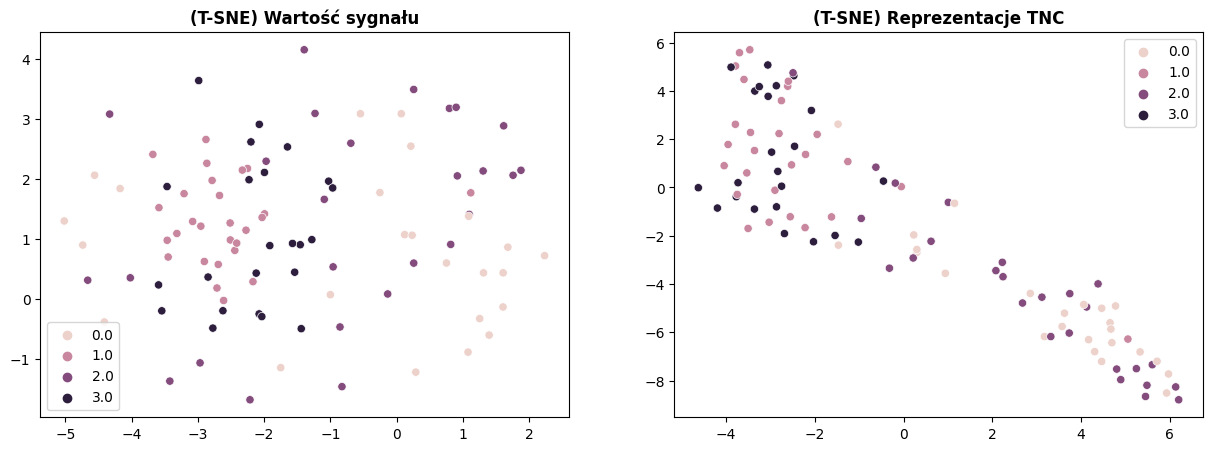

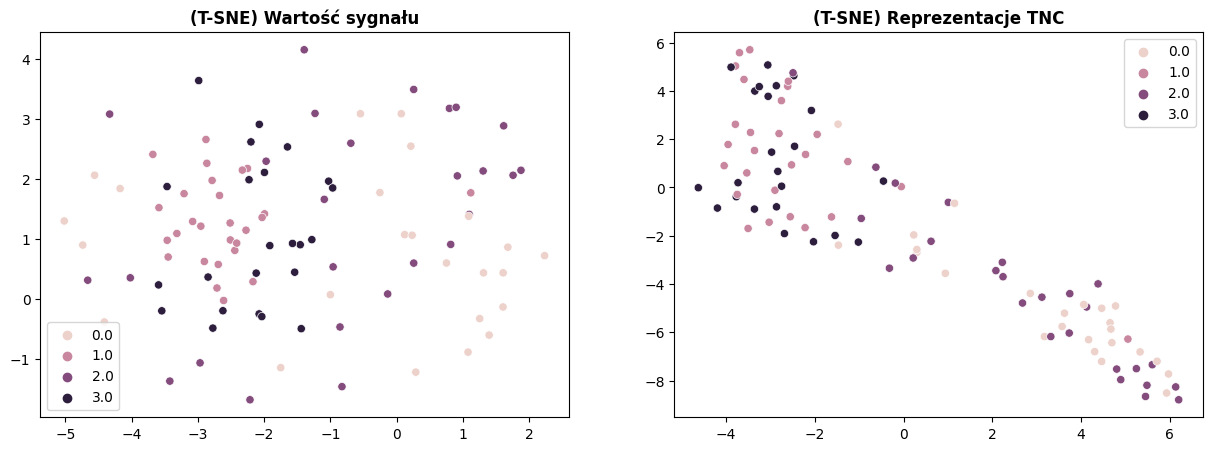

In [ ]:
from src.utils import visualize_embeddings
from src.evaluations import evaluate_model


def visualize(name: str):
    best_tnc_model = TNCModel.load_from_checkpoint(
        checkpoint_path=f"./data/checkpoints/{name}/model.ckpt"
    )

    best_encoder = best_tnc_model.encoder

    dataset = torch.load("./data/simulated.pt")

    fig = visualize_embeddings(
        x_all=dataset["x_all"],
        y_all=dataset["y_all"],
        encoder=best_encoder,
        window_size=best_tnc_model.hparams["window_size"],
    )
    return fig


visualize(default_hparams["name"])

In [ ]:
def evaluate_classification_clustering(name: str):
    best_tnc_model = TNCModel.load_from_checkpoint(
        checkpoint_path=f"./data/checkpoints/{name}/model.ckpt"
    )

    best_encoder = best_tnc_model.encoder

    dataset = torch.load("./data/simulated.pt")
    
    metrics = evaluate_model(
        dataset=dataset,
        encoder=best_encoder,
        window_size=best_tnc_model.hparams["window_size"],
    )
    
    return metrics


evaluate_classification_clustering(default_hparams["name"])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


{'auc': {'train': 0.8981668354970989,
  'val': 0.8880240418315082,
  'test': 0.8937790673394987},
 'cluster': {'silhouette': 0.47192803, 'davies_bouldin': 0.7431453127850053}}

## Zadanie 2.6. Badanie hiperparametrów metody TNC (3 pkt)
Korzystając z podanych funkcji `train()` oraz `evaluate_classification_clustering()` zbadaj następujące hiperparametry:
- `window_size` (zbadaj co najmniej 3 wartości)
- `w` (zbadaj co najmniej 3 wartości)

Jeśli uczenie modelu będzie zbyt czasochłonne można zredukować liczbę epok. Każdy z parametrów można zbadać osobno - nie ma potrzeby przeglądania ich przekroju. Analizy powinny być prowadzone na podstawie metryk: AUC (zbiór testowy) oraz metryki klasteryzacji (Silhouette oraz Davies-Bouldin). Utwórz tabelki, które podsumują wyniki eksperymentów. Skomentuj wyniki

In [ ]:
# TU WPISZ KOD
window_sizes = [20,50,80]
ws = [0.01,0.05,0.1]

hparams_testing = {
    "in_dim": 3,
    "hidden_dim": 100,
    "emb_dim": 10,
    "window_size": 50,
    "mc_sample_size": 40,
    "w": 0.05,
    "num_epochs": 30,
    "lr": 1e-3,
    "weight_decay": 1e-3,
    "batch_size": 10,
    "name": "default",
}
metrics_window_sizes = []

for w_s in window_sizes:
  hparams_testing["window_size"] = w_s
  hparams_testing["name"] = 'test_windows=' + str(w_s)

  train(hparams=hparams_testing)

  metrics = (evaluate_classification_clustering(hparams_testing["name"]))

  final_metrics = {
    'AUC': np.round(metrics['auc']['test'],4),
    'Sil.': np.round(metrics['cluster']['silhouette'],4),
    'D-B': np.round(metrics['cluster']['davies_bouldin'],4)
    }

  metrics_window_sizes.append(final_metrics)

metrics_ws = []


for w in ws:
  hparams_testing["w"] = w
  hparams_testing["name"] = 'test_w=' + str(w)

  train(hparams=hparams_testing)

  metrics = (evaluate_classification_clustering(hparams_testing["name"]))

  final_metrics = {
    'AUC': np.round(metrics['auc']['test'],4),
    'Sil.': np.round(metrics['cluster']['silhouette'],4),
    'D-B': np.round(metrics['cluster']['davies_bouldin'],4)
    }

  metrics_ws.append(final_metrics)

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type            | Params
---------------------------------------------
0 | encoder  | GRUEncoder      | 65.0 K
1 | _loss_fn | TNCLossFunction | 881   
---------------------------------------------
65.9 K    Trainable params
0         Non-trainable params
65.9 K    Total params
0.264     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilit

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilit

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type            | Params
---------------------------------------------
0 | encoder  | GRUEncoder      | 65.0 K
1 | _loss_fn | TNCLossFunction | 881   
---------------------------------------------
65.9 K    Trainable params
0         N

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type            | Params
---------------------------------------------
0 | encoder  | GRUEncoder      | 65.0 K
1 | _loss_fn | TNCLossFunction | 881   
---------------------------------------------
65.9 K    Trainable params
0         N

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type            | Params
---------------------------------------------
0 | encoder  | GRUEncoder      | 65.0 K
1 | _loss_fn | TNCLossFunction | 881   
---------------------------------------------
65.9 K    Trainable params
0         N

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
import pandas as pd
df = pd.DataFrame({'window_sizes': window_sizes, 'metrics': metrics_window_sizes})
df

,window_sizes,metrics
0,20,"{'AUC': 0.8475, 'Sil.': 0.5777, 'D-B': 0.5338}"
1,50,"{'AUC': 0.8796, 'Sil.': 0.5354, 'D-B': 0.6379}"
2,80,"{'AUC': 0.7108, 'Sil.': 0.465, 'D-B': 0.6252}"


In [ ]:
# został ustawiony window_size=80, dlatego gorsze wyniki,
# ale widać dla którego w wyszło najlepiej
df = pd.DataFrame({'w': ws, 'metrics': metrics_ws})
df

,w,metrics
0,0.01,"{'AUC': 0.7074, 'Sil.': 0.4723, 'D-B': 0.6125}"
1,0.05,"{'AUC': 0.7108, 'Sil.': 0.465, 'D-B': 0.6252}"
2,0.10,"{'AUC': 0.7081, 'Sil.': 0.4375, 'D-B': 0.6816}"


Dla sprawdzonych parametrów window_size widoczne jest, że trzy użyte metryki są zdecydowanie najlepsze dla rozmiaru 50, skrócenie długości okna lub wysłużenie prowadzi do pogorszenia metryk. Jednak widać, że dla mniejszego rozmiaru wzrosła miara Silhouette, co świadczy o jej polepszeniu, oraz zmalała davies_bouldin, co świadczy o lepszym rozdzieleniu klastrów.

Analogicznie mają się sprawy dla wartości w, dla środkowej wartości 0.05 najlepsze mamy AUC, ale dwie pozostałe metryki lepsze są dla mniejszej wartości w.